In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 167 (delta 29), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (167/167), 1.50 MiB | 8.46 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=1121 sha256=6f0a03bab919b4b554f2310768bcb9258ed84d39313ad653f07553b9787b4fcc
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgaqt7fd/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc


In [3]:
from deepflows.data_generators import celeba
from deepflows import utils
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
import pandas as pd
from scipy import linalg as la
from math import log, pi, exp
from deepflows.data_generators import stochasticShapes
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms

device = utils.set_gpu(True)

Note: GPU is not available


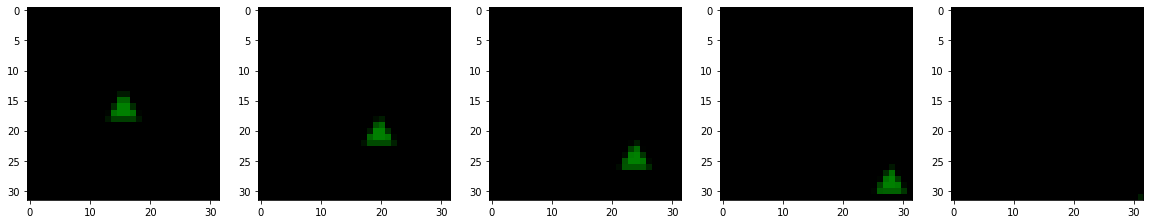

In [4]:
batch_size = 32
dataset = stochasticShapes.MovingShapes(root_dir = "/content/gdrive/My Drive/movingShapes.h5")
trainset, valset = torch.utils.data.random_split(dataset, [9000, 1000])

train_loader_t = DataLoader(valset, batch_size=10, shuffle=True)

x_plot = next(iter(train_loader_t))[0].permute(0,3,2,1)

fig, ax = plt.subplots(1, 5, figsize = (20,5))
ax[0].imshow(x_plot[0])
ax[1].imshow(x_plot[1])
ax[2].imshow(x_plot[2])
ax[3].imshow(x_plot[3])
ax[4].imshow(x_plot[4])
plt.show()

In [5]:
logabs = lambda x: torch.log(torch.abs(x))


class ConditionNet(nn.Module):
    def __init__(self, in_channels, output_channels, height, width, hid_dim = 32):
        """
        A condition net. It takes in and out channels as input.
        Output is x, it is usually used to estimate the parameters for the affine transformation, hence
        the output dimensions are usually multiplied by 2, as we need two parameters.
        """
        super(ConditionNet, self).__init__()
        layers = [WeightNormConv2d(in_channels, in_channels, (2, 2), stride=2, padding= 0 ),
                  nn.ReLU(),
                  WeightNormConv2d(in_channels, in_channels, (2, 2), stride=2, padding=0),
                  nn.ReLU(),
                  WeightNormConv2d(in_channels, in_channels, (2, 2), stride=2, padding=0),
                  nn.ReLU()]
        h, w = utils.get_layer_size([height, width], kernels=[2, 2, 2], paddings=[0, 0, 0], strides=[2, 2, 2],
                                    dilations=[1, 1, 1])
        self.net = nn.Sequential(*layers)
        layers_flatten = [nn.Linear(h * w * (in_channels), 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(),
                          nn.Linear(32, output_channels), nn.Tanh()]

        self.net_flatten = nn.Sequential(*layers_flatten)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.net(x)
        x = x.view(batch_size, -1)
        x = self.net_flatten(x)
        x = x.view(batch_size, -1, 1, 1)
        return x

class WeightNormConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride=1, padding=0,
                 bias=True):
        super(WeightNormConv2d, self).__init__()
        self.conv = nn.utils.weight_norm(
            nn.Conv2d(in_dim, out_dim, kernel_size,
                      stride=stride, padding=padding, bias=bias))

    def forward(self, x):
        return self.conv(x)



class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0))

    def forward(self, x):
        return x + self.block(x)


class SimpleResnet(nn.Module):
    def __init__(self, in_channels, out_channels, n_filters=64, n_blocks=4):
        super(SimpleResnet, self).__init__()
        layers = [WeightNormConv2d(in_channels, n_filters, (3, 3), stride=1, padding=1),
                  nn.ReLU()]
        for _ in range(n_blocks):
            layers.append(ResnetBlock(n_filters))
        layers.append(nn.ReLU())
        layers.append(WeightNormConv2d(n_filters, out_channels, (3, 3), stride=1, padding=1))
        self.resnet = nn.Sequential(*layers)

    def forward(self, x):
        return self.resnet(x)

class ConditionalInvConv(nn.Module):
    def __init__(self, x_channels, c_channels, height, width):
        """
        Conditional 1x1 convolution
        Takes in the argument x, and the conditional.
        Convolution W is found by NN.
        """
        super(ConditionalInvConv, self).__init__()
        self.x_channels = x_channels
        self.ConditionalNet = ConditionNet(in_channels = c_channels, 
                                           output_channels= x_channels * x_channels, 
                                           height = height, width = width)
    
    def forward(self, x, condition, reverse=False):
        B, C, H, Wi = x.size()
        W = self.ConditionalNet(condition)
        W = W.view(B, self.x_channels, self.x_channels)
        logdet = torch.slogdet(W)[1]
        W = W.view(B, self.x_channels, self.x_channels, 1, 1)
        x = x.reshape(1, B * C, H, Wi)  
        B_k, C_i_k, C_o_k, H_k, W_k = W.size()
        W = W.view(B_k * C_i_k, C_o_k, H_k, W_k)

        if reverse:
            W = W.view(B, self.x_channels, self.x_channels)
            W = torch.inverse(W.double()).float().view(B, self.x_channels, self.x_channels, 1, 1)
            W = W.reshape(B_k * C_i_k, C_o_k, H_k, W_k)
            out = F.conv2d(x, W, groups=B)
            out = out.view(B, C, H, Wi)
        else:
            out = F.conv2d(x, W, groups=B)
            out = out.view(B, C, H, Wi)
        
        return out, logdet.view(B, 1, 1, 1)


class ConditionalActNorm(nn.Module):
    def __init__(self, x_channels, c_channels, height, width):
        """
        Applied conditional ActNorm, finds the conditional shift. From the condition.
        """
        super(ConditionalActNorm, self).__init__()
        self.c_channels = c_channels
        self.x_channels = x_channels
        self.ConditionalNet = ConditionNet(in_channels = self.c_channels, output_channels = 2 * self.x_channels, 
                                           height = height, width = width)

    def forward(self, x, condition, reverse=False):
        output = self.ConditionalNet(condition)
        log_scale, shift = output.split(output.shape[1] // 2, dim=1)
        if reverse:
            return (x - shift) * torch.exp(-log_scale), log_scale
        else:
            return x * torch.exp(log_scale) + shift, log_scale

# See this https://github.com/ndrplz/ConvLSTM_pytorch and https://www.quora.com/What-is-the-difference-between-ConvLSTM-and-CNN-LSTM
class ConvLSTMLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias, dropout = 0):
        super(ConvLSTMLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.bias = bias
        self.conv = nn.Conv2d(in_channels = self.input_dim + self.hidden_dim,
                              out_channels = 4 * self.hidden_dim,
                              kernel_size = self.kernel_size,
                              padding = self.padding,
                              bias = self.bias)
        self.dropout = nn.Dropout2d(p = dropout)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        combined_conv = self.dropout(combined_conv)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_states(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))
        
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True, dropout = 0):
        super(ConvLSTM, self).__init__()
        
        self.LSTMlayer = ConvLSTMLayer(input_dim=input_dim,
                                          hidden_dim=hidden_dim,
                                          kernel_size=kernel_size,
                                          bias=bias, dropout=dropout)
    def forward(self, x, hidden_states):
        ht, ct = hidden_states
        b, seq_len, channel, h, w = x.size()
        #print(seq_len)
        for t in range(seq_len):
            ht, ct = self.LSTMlayer(input_tensor=x[:, t, :, :, :],
                                              cur_state=[ht, ct])
        return ht, ct



In [6]:

class ConditionalAffineCheckerboardTransform(nn.Module):
    def __init__(self, type, x_channels, c_channels):
        super(ConditionalAffineCheckerboardTransform, self).__init__()
        
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)

        self.x_channels = x_channels
        self.c_channels = c_channels
        self.resnet = SimpleResnet(in_channels=self.x_channels + self.c_channels,
                                   out_channels=self.x_channels * 2, n_blocks = 4)

    def build_mask(self, type=1.0):
        # if type == 1.0, the top left corner will be 1.0
        # if type == 0.0, the top left corner will be 0.0
        mask = np.arange(32).reshape(-1, 1) + np.arange(32)
        mask = np.mod(type + mask, 2)
        mask = mask.reshape(-1, 1, 32, 32)
        return torch.tensor(mask.astype('float32')).to(device)

    def forward(self, x, condition, reverse=False):
        # returns transform(x), log_det
        batch_size, n_channels, _, _ = x.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)
        x_ = x * mask

        # Takes the concatinating condition on the x.
        log_s, t = self.resnet(torch.cat((x_, condition), dim=1)).split(n_channels, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        if reverse:
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

#change all these channels
class ConditionalAffineChannelTransform(nn.Module):
    def __init__(self, modify_top, x_channels, c_channels):
        super(ConditionalAffineChannelTransform, self).__init__()
        self.modify_top = modify_top
        self.x_channels = x_channels
        self.c_channels = c_channels
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)

        self.resnet = SimpleResnet(in_channels=self.x_channels // 2 + self.c_channels,
                                   out_channels=self.x_channels, n_blocks = 4)

    def forward(self, x, condition, reverse=False):
        if self.modify_top:
            on, off = x.split(self.x_channels // 2, dim=1)
        else:
            off, on = x.split(self.x_channels // 2, dim=1)
        log_s, t = self.resnet(torch.cat((off, condition), dim=1)).split(self.x_channels // 2, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        if reverse:
            on = (on - t) * torch.exp(-log_s)
        else:
            on = on * torch.exp(log_s) + t

        if self.modify_top:
            return torch.cat([on, off], dim=1), torch.cat([log_s, torch.zeros_like(log_s)], dim=1)
        else:
            return torch.cat([off, on], dim=1), torch.cat([torch.zeros_like(log_s), log_s], dim=1)

class GlowConditional(nn.Module):
    def __init__(self, x_dims, c_channels):
        super(GlowConditional, self).__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        self.c_channels = c_channels
        self.features_channels = 16
        self.x_channels, self.height, self.width = x_dims
        
        self.counter = 0
        self.ht = nn.Parameter(torch.zeros(batch_size, self.features_channels, 32, 32, device=device))
        self.ct = nn.Parameter(torch.zeros(batch_size, self.features_channels, 32, 32, device=device))

        ### Conditional feature extractor.
        self.FeatureExtractorNet = ConvLSTM(input_dim = 3, hidden_dim = self.features_channels, kernel_size = (3,3)).to(device)

        self.checker_transforms1 = nn.ModuleList([
            ConditionalAffineCheckerboardTransform(type=1.0, x_channels=self.x_channels, c_channels=self.features_channels),
            ConditionalActNorm(x_channels=self.x_channels, c_channels=self.features_channels, height = self.height, width = self.width),
            ConditionalAffineCheckerboardTransform(type=0., x_channels=self.x_channels, c_channels=self.features_channels),
            ConditionalActNorm(x_channels=self.x_channels, c_channels=self.features_channels, height = self.height, width = self.width),
            ConditionalAffineCheckerboardTransform(type=1.0, x_channels=self.x_channels, c_channels=self.features_channels),
            ConditionalActNorm(x_channels=self.x_channels, c_channels=self.features_channels, height = self.height, width = self.width),
            ConditionalAffineCheckerboardTransform(type=0., x_channels=self.x_channels, c_channels=self.features_channels)
        ])
        
        # Here it is squeezed so the channels is *4 
        self.channel_transforms = nn.ModuleList([
            ConditionalInvConv(x_channels=self.x_channels * 4, c_channels=self.features_channels * 4, height = self.height // 2, width = self.width // 2),                                      
            ConditionalAffineChannelTransform(True, x_channels=self.x_channels * 4, c_channels=self.features_channels * 4),
            ConditionalActNorm(x_channels=self.x_channels * 4, c_channels=self.features_channels * 4, height = self.height // 2, width = self.width // 2),
            ConditionalAffineChannelTransform(False, x_channels=self.x_channels * 4, c_channels=self.features_channels * 4),
            ConditionalActNorm(x_channels=self.x_channels * 4, c_channels=self.features_channels * 4, height = self.height // 2, width = self.width // 2),
            ConditionalAffineChannelTransform(True, x_channels=self.x_channels * 4, c_channels=self.features_channels * 4),
        ])
        
        self.checker_transforms2 = nn.ModuleList([
            ConditionalInvConv(x_channels=self.x_channels, c_channels=self.features_channels, height = self.height, width = self.width),                                        
            ConditionalAffineCheckerboardTransform(type=1.0, x_channels=self.x_channels, c_channels=self.features_channels),
            ConditionalActNorm(x_channels=self.x_channels, c_channels=self.features_channels, height = self.height, width = self.width),
            ConditionalAffineCheckerboardTransform(type=0., x_channels=self.x_channels, c_channels=self.features_channels),
            ConditionalActNorm(x_channels=self.x_channels, c_channels=self.features_channels, height = self.height, width = self.width),
            ConditionalAffineCheckerboardTransform(type=1.0, x_channels=self.x_channels, c_channels=self.features_channels),
        ])

    def squeeze(self, x):
        # C x H x W -> 4C x H/2 x W/2
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x

    def undo_squeeze(self, x):
        #  4C x H/2 x W/2  ->  C x H x W
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x

    def g(self, z, condition):
        # z -> x (inverse of f)
        conzf, ct = self.FeatureExtractorNet(condition.unsqueeze(dim=1), (self.ht, self.ct))
        x = z
        for op in reversed(self.checker_transforms2):
            x, _ = op.forward(x, conzf, reverse=True)
        x, conzf = self.squeeze(x), self.squeeze(conzf)
        for op in reversed(self.channel_transforms):
            x, _ = op.forward(x, conzf, reverse=True)
        x, conzf= self.undo_squeeze(x), self.undo_squeeze(conzf)
        for op in reversed(self.checker_transforms1):
            x, _ = op.forward(x, conzf, reverse=True)
        
        return x

    def f(self, x, condition):
        # maps x -> z, and returns the log determinant (not reduced)
        z = x
        conzf, ct = self.FeatureExtractorNet(condition.unsqueeze(dim=1), (self.ht, self.ct))
        z, log_det = z, torch.zeros_like(z)
        for op in self.checker_transforms1:
            z, delta_log_det = op.forward(z, conzf, reverse=False)
            log_det += delta_log_det
        z, log_det, conzf = self.squeeze(z), self.squeeze(log_det), self.squeeze(conzf)
        for op in self.channel_transforms:
            z, delta_log_det = op.forward(z, conzf, reverse=False)
            log_det += delta_log_det
        z, log_det, conzf = self.undo_squeeze(z), self.undo_squeeze(log_det), self.undo_squeeze(conzf)
        for op in self.checker_transforms2:
            z, delta_log_det = op.forward(z, conzf, reverse=False)
            log_det += delta_log_det
        return z, log_det
        
    def log_prob(self, x, condition):
        z, log_det = self.f(x, condition)
        return torch.sum(log_det, [1, 2, 3]) + torch.sum(self.prior.log_prob(z), [1, 2, 3])

    def sample(self, num_samples, condition):
        z = self.prior.sample([num_samples, self.x_channels, self.height, self.width])
        return self.g(z, condition)

In [7]:

class Solver(object):
    def __init__(self, learning_rate=5e-4, n_epochs=128):
        self.train_loader, self.val_loader = self.create_loaders()
        self.log_interval = 100
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.n_batches_in_epoch = len(self.train_loader)

    def build(self):
      #change here for new input
        self.flow = GlowConditional((3, 32, 32), 3).to(device)
        self.optimizer = torch.optim.Adam(self.flow.parameters(), lr=self.learning_rate)

    def create_loaders(self):
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False, drop_last = True)
        test_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False, drop_last = True)
        return train_loader, test_loader

    def preprocess(self, x, reverse=False, dequantize=True):
        if reverse:
            x = 1.0 / (1 + torch.exp(-x))
            x -= 0.05
            x /= 0.9
            return x
        else:
            # dequantization
            if dequantize:
                x += torch.rand_like(x) / 2**5
            max_value = x.max()
            x /= max_value

            # logit operation
            x *= 0.9
            x += 0.05
            logit = torch.log(x) - torch.log(1.0 - x)
            log_det = torch.nn.functional.softplus(logit) + torch.nn.functional.softplus(-logit) \
                      + torch.log(torch.tensor(0.9)) - torch.log(torch.tensor(max_value))
            return logit, torch.mean(torch.sum(log_det, dim=(2, 3, 4)), dim=1)

    def train(self):
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1

            self.flow.train()
            self.batch_loss_history = []

            for batch_i, image in enumerate(tqdm(
                    self.train_loader, desc='Batch', leave=False)):
                
                batch_i += 1
                image = Variable(image).to(device)
                logit_x, log_det = self.preprocess(image.float(), dequantize=True)
                
                for t in range(2, 5):
                  
                  log_prob = self.flow.log_prob(logit_x[:,t,:,:,:], logit_x[:,t-1,:,:,:])
                  
                  log_prob += log_det

                batch_loss = -torch.mean(log_prob) / (3 * 32.0 * 32.0)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                batch_loss = float(batch_loss.data)
                self.batch_loss_history.append(batch_loss)

            epoch_loss = np.mean(self.batch_loss_history)
            tqdm.write(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')

            if epoch_i % 75 == 0:
                self.save_model("GlowConditional{}.model".format(str(epoch_i)))
            train_losses.append(epoch_loss)
            val_losses.append(self.get_loss(self.val_loader))
            np.save("train_losses.npy", np.array(train_losses))
            np.save("val_losses.npy", np.array(val_losses))

        self.save_model("GlowConditional_final.model")
        return train_losses, val_losses

    def get_loss(self, loader):
        """Compute error on provided data set"""
        errors = []

        # cuda.synchronize()
        start = time.time()

        self.flow.eval()

        for image in loader:
            with torch.no_grad():
                image = image.to(device)
                logit_x, log_det = self.preprocess(image.float(), dequantize=True)
                for t in range(2, 5):
                  
                  log_prob = self.flow.log_prob(logit_x[:,t,:,:,:], logit_x[:,t-1,:,:,:])
                  log_prob += log_det

                loss = -torch.mean(log_prob) / (3 * 32.0 * 32.0)
                error = float(loss.data)
                errors.append(error)
        
        time_test = time.time() - start
        log_string = f'Calc done! | It took {time_test:.1f}s | '
        log_string += f'Loss: {np.mean(errors):.2f}'
        tqdm.write(log_string)
        return np.mean(errors)

    def sample(self, num_samples):
        with torch.no_grad():
            raw_samples = self.flow.sample(num_samples).cpu()
            samples = self.preprocess(raw_samples, reverse=True)
            return samples.cpu().numpy()

    def save_model(self, filename):
        torch.save(self.flow, filename)

    def load_model(self, filename):
        self.flow = torch.load(filename, map_location="cpu")

In [8]:
solver = Solver(n_epochs=5, learning_rate=0.001)
solver.build()
train, val = solver.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


KeyboardInterrupt: ignored

In [ ]:
test_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False, drop_last = True)

In [ ]:
x=next(iter(test_loader)).to(device)

#Preprocess
x_cont, _ = solver.preprocess(x, dequantize=True)

#Sample from distribution
prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
z = prior.sample([batch_size, 3, 32, 32])

t=2
with torch.no_grad():
  samples=solver.flow.g(z.to(device), x[:, t, :, :, :].to(device))

# Preprocess samples
samples=solver.preprocess(samples, dequantize=False, reverse=True)

# Our true values
conzre=solver.preprocess(x[:, t, :, :, :], dequantize=False, reverse=True)
zre=solver.preprocess(x[:, t + 1, :, :, :], dequantize=False, reverse=True)
zre2=solver.preprocess(x[:, t, :, :, :], dequantize=False, reverse=True)

fig, axes = plt.subplots(3, 10 , figsize = (20,5))

j=0
k=0


for i in range(0, 10):

  axes[k*2, j].imshow(zre2[i].permute(1,2,0).detach().cpu().numpy())
  axes[k*2, j].set_title('t, true')
  axes[k*2, j].set_axis_off()
  kk = conzre[i]/4*4
  kk=samples[i]
  axes[k*2+1, j].imshow(kk.permute(1,2,0).detach().cpu().numpy())
  axes[k*2+1, j].set_title('t+1, sampled')
  axes[k*2+1, j].set_axis_off()
  
  axes[k*2+2, j].imshow(zre[i].permute(1,2,0).detach().cpu().numpy())
  axes[k*2+2, j].set_title('t+1, true')
  axes[k*2+2, j].set_axis_off()
  k+=1
  if k*2 % 2 == 0:
    j += 1
    k = 0

fig.tight_layout()